In [1]:
# used files: Project
import os
import importlib
import pickle
import pandas as pd
import numpy as np
from sklearn import metrics
import project
from project import Project 
import functions
from functions import *



/anaconda/envs/xaienv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [7]:
importlib.reload(project)
from project import *

In [8]:
np.set_printoptions(precision=2,suppress=True)

In [2]:
ant_project = Project('ANT')
ant_project.set_train_test()
ant_project.prepare_data()

In [2]:


# Train model for ANT 
ant_project.train_global_model('SVM')
global_model = ant_project.models['SVM']
# TODO save model to file after initialising and fitting

X_test = ant_project.X_test
y_test = ant_project.y_test
X_train = ant_project.X_train_rs
y_train = ant_project.y_train_rs
project_name = ant_project.name

# predict model
pred = global_model.predict(X_test)
defect_prob = global_model.predict_proba(X_test)[:,1]

# evaluate model preformance
evaluate_model_performance(ant_project,'SVM')


Dataset project: ANT
SVM Training accuracy(in %): 76.83397683397683
SVM Test accuracy(in %): 76.51006711409396
SVM precision(in %): 48.08510638297872
SVM recall(in %): 68.07228915662651
SVM f1(in %): 56.35910224438903


In [3]:
# Sample 100 instances to compare accuracy of methods
def sample(quantity, X_test,y_test):
    test_data = X_test.copy()
    test_data['defect'] = y_test
    test_data['freq'] = 1./test_data.groupby('defect')['defect'].transform('count')
    # sampled data with half clean and half defective
    sampled_data = test_data.sample(quantity,weights = test_data.freq, random_state=1, replace=False)
    x_cols = sampled_data.columns[:-2].values
    test_data_x = sampled_data[x_cols]
    test_data_y = sampled_data['defect']
    return test_data_x, test_data_y, sampled_data

In [4]:
from aix360.metrics import *
from shap import KernelExplainer

def generate_explanations(explainer,X_test,y_test, global_model):
    explanations = []
    if isinstance(explainer, KernelExplainer):
        shap_values = explainer.shap_values(X_test)

    for i in range(0,len(X_test)):
        X_explain = X_test.iloc[[i]]
        y_explain = y_test.iloc[[i]]
        row_index = str(X_explain.index[0]) #name of instance
        # check which explainer
        if isinstance(explainer,LimeTabularExplainer):
            exp, synt_inst, synt_inst_for_local_model, selected_feature_indices, local_model = explainer.explain_instance(X_test.iloc[i], global_model.predict_proba, num_samples=2110)
            explanation = {}
            explanation['rule'] = exp
            explanation['synthetic_instance_for_global_model'] = synt_inst
            explanation['synthetic_instance_for_local_model'] = synt_inst_for_local_model #10 most important features binary rep
            explanation['local_model'] = local_model
            explanation['selected_feature_indices'] = selected_feature_indices #10 most important feature indexes
            explanation['name'] = row_index

        elif isinstance(explainer, PyExplainer):
            explanation = explainer.explain(X_explain, y_explain, search_function ='CrossoverInterpolation')
            explanation['name'] = row_index
            explanation['local_model'] = explanation['local_rulefit_model']
            del explanation['local_rulefit_model']
            # explanation['local_prediction'] =  explanation['local_model'].predict_proba( test_data_x.iloc[[i]].values)[0][0]
            print(i)
        
        elif isinstance(explainer, KernelExplainer):
            explanation = {}
            explanation['name'] = row_index
            explanation['shap_values'] = shap_values[i]
            # row_values, row_expected_values, row_mask_shapes, main_effects = explainer.explain_row()
        # faithfulness = faithfulness_metric(explanation['local_model'],X_explain,)

        explanations.append(explanation)
    return explanations 

In [5]:
from lime.lime_tabular import LimeTabularExplainer
from pyexplainer.pyexplainer_pyexplainer import *
import shap
from shap import KernelExplainer

dep = 'defect'
class_label = ['clean','defect']
random_state = 1

def get_explanations(project_name,explain_method,model_name,X_train,y_train,global_model,random_state=1,class_label =['clean','defect'] ):
    # explain_method - str: 'lime','pyExp', 'shap'
    filepath = 'explanations/' + project_name + '_'+ model_name +'_'+explain_method+'_explanations' +'.pkl'

    if explain_method == 'lime':
        explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, 
                                        class_names=class_label, random_state=random_state)
    elif explain_method == 'pyExp':
        explainer = PyExplainer(X_train, y_train, X_train.columns, 'defect', global_model, class_label)
    elif explain_method == 'shap':
        f = lambda x: global_model.predict_proba(x)[:,1]
        explainer = KernelExplainer(f, X_train)
    else: 
        print('explain_method must be either lime, pyExp or shap')

    if os.path.exists(filepath):
        explanations = pickle.load(open(filepath,'rb'))
    else:
        explanations = generate_explanations(explainer,test_data_x,test_data_y,global_model)
        pickle.dump(explanations,open(filepath,'wb'))

    return explainer,explanations

In [6]:
def show_model_performance(global_preds,lime_preds,py_preds,shap_preds):
    print('lime')
    print('precision: ', metrics.precision_score(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
    print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
    print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
    # print(metrics.log_loss (np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
    print('avg probability diff: ',avg_proba_diff(global_preds, lime_preds))

    print('pyExplainer')
    print('precision: ',metrics.precision_score(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
    print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
    print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
    print('avg probability diff: ',avg_proba_diff(global_preds, py_preds))

    print('shap')
    print('precision: ',metrics.precision_score(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
    print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
    print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
    print('avg probability diff: ',avg_proba_diff(global_preds, shap_preds))

In [7]:
# ibm aix360 metrics - faithfulness and monotonicity
def faithfulness(model, x, coefs, base):
    #find predicted class
    pred_class = model.predict(x.reshape(1,-1))[0].astype(int)
    
    #find indexs of coefficients in decreasing order of value
    ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
    pred_probs = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        x_copy = x.copy()
        x_copy[ind] = base[ind]
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]
        if (x_copy_pr[0][pred_class]==np.nan):
            print(x_copy_pr)
    print(pred_probs)
    return -np.corrcoef(coefs, pred_probs)[0,1]
    
def monotonicity(model, x, coefs, base):
    #find predicted class
    pred_class = model.predict(x.reshape(1,-1))[0].astype(int)

    x_copy = base.copy()

    #find indexs of coefficients in increasing order of value
    ar = np.argsort(coefs)
    pred_probs = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        x_copy[ind] = x[ind]
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]

    return np.all(np.diff(pred_probs[ar]) >= 0)

# calculate average percentage difference between prediction probabilities of global model and local model
def avg_proba_diff(global_pred_proba, local_pred_proba):
    # print('avg ', np.sum(local_pred_proba)/len(local_pred_proba))
    if len(global_pred_proba)!= len(local_pred_proba):
        print('unmatched length')
        return

    percentage_diffs = [(abs(global_pred_proba[i]-local_pred_proba[i])) for i in range(0, len(global_pred_proba))]
    
    return np.sum(percentage_diffs)/len(global_pred_proba)

In [8]:
def faithfulness_and_monotonicity(test_data_x,lime_explanations, shap_explanations):
    lime_faithfulness = []
    lime_monotonicity = []
    shap_faithfulness = []
    shap_monotonicity = []
    for i in range(len(test_data_x)):
        local_preds = list(lime_explanations[i]['rule'].local_pred.values())[0][0]
        name = lime_explanations[i]['name']
        lime_exp = lime_explanations[i]['rule']
        x = test_data_x.iloc[i].values # data row type ndarray
        coefs = np.zeros(x.shape[0])  # coefficients (weights) corresponding to attribute importance
        # pred_class = int(np.round(global_preds[i]))
        for v in lime_exp.local_exp[1]:
            coefs[v[0]] = v[1]
        base = np.zeros(x.shape[0])
        fmlime = faithfulness(global_model,x,coefs,base)
        lime_faithfulness.append(fmlime)
        mlime = monotonicity(global_model,x,coefs,base)
        lime_monotonicity.append(mlime)

        coefs_shap = shap_explanations[i]['shap_values']
        fmshap = faithfulness(global_model,x,coefs_shap,base)
        shap_faithfulness.append(fmshap)
        mshap = monotonicity(global_model,x,coefs_shap,base)
        shap_monotonicity.append(mshap)
        # print('Lime local prediction ' , local_preds)
        # print('Global model prediction', lime_explanations[0]['rule'].predict_proba[1]) #global model prediction
    lime_avg_faithfulness = sum(lime_faithfulness)/len(lime_faithfulness)
    lime_percentage_monotonicity = sum(lime_monotonicity)/len(lime_monotonicity)
    shap_avg_faithfulness = sum(shap_faithfulness)/len(shap_faithfulness)
    shap_percentage_monotonicity = sum(shap_monotonicity)/len(shap_monotonicity)
    print("lime_avg_faithfulness: ",lime_avg_faithfulness)
    print("lime_percentage_monotonicity: " ,lime_percentage_monotonicity)
    print("shap_avg_faithfulness: ", shap_avg_faithfulness)
    print("shap_percentage_monotonicity: ", shap_percentage_monotonicity)
    return lime_faithfulness,lime_monotonicity,shap_faithfulness,shap_monotonicity


In [24]:
def get_percent_unique_explanation(explanation_list):
    total_exp = len(explanation_list)
    total_unique_exp = len(set(explanation_list))
    percent_unique = (total_unique_exp/total_exp)*100

    count_exp = Counter(explanation_list)
    max_exp_count = max(list(count_exp.values()))
    percent_dup_explanation = (max_exp_count/total_exp)*100

    print('% unique explanation is',round(percent_unique,2))
    print('% duplicate explanation is', round(percent_dup_explanation))

In [9]:
test_data_x, test_data_y, sampled_data = sample(100,X_test,y_test)

In [10]:
# Sample 100 instances to compare accuracy of methods
ant_test_data = X_test.copy()
ant_test_data['defect'] = y_test
ant_test_data['freq'] = 1./ant_test_data.groupby('defect')['defect'].transform('count')
# sampled data with half clean and half defective
# sampled_data = ant_test_data.sample(100,weights = ant_test_data.freq, random_state=1, replace=False)
x_cols = sampled_data.columns[:-2].values
test_data_x = sampled_data[x_cols]
test_data_y = sampled_data['defect']

In [11]:
limeExp,lime_explanations = get_explanations(project_name, 'lime','SVM',X_train,y_train,global_model )

In [12]:
pyExp,pyexplanations = get_explanations(project_name, 'pyExp','SVM',X_train,y_train,global_model )

In [13]:
shapExp,shap_explanations = get_explanations(project_name, 'shap','SVM',X_train,y_train,global_model )

X does not have valid feature names, but SVC was fitted with feature names
Using 518 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Example of pyExplainer explanation

In [14]:
pyexp1 = pyexplanations[0]
print(pyexp1.keys())
rules = pyExp.explain(pyexp1["X_explain"],pyexp1["y_explain"],search_function='crossoverinterpolation',random_state=0,reuse_local_model=True)


dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'top_k_positive_rules', 'top_k_negative_rules', 'name', 'local_model'])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


PyExplainer explanation
-----------------------------------------------------------------
Method for generating explanations from local model - RuleFit algorithm
1. Tree based model (GradientBoostingClassifier) is trained and used to create decision rules (new features)
2. Sparse Linear model (LogisticRegressionCV) is trained to select best features/feature rules by assigning weights

------------------------------------------------------------------
explanation = pyExp.explain(X_explain,y_explain, search_function='crossoverinterpolation',random_state=0,reuse_local_model=True)

returns a dictionary with keys: 
- dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'top_k_positive_rules', 'top_k_negative_rules', 'local_rulefit_model'])

X_explain is the features of the instance of interest

y_explain is the prediction of the instance of interest

indep is the list of independent variable names (feature names)

dep is the dependent variable name (name of prediction column)

In [16]:
print(pyexp1.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'top_k_positive_rules', 'top_k_negative_rules', 'name', 'local_model'])


In [11]:
print(pyexp1["X_explain"])

                                        wmc  dit  noc  cbo  rfc  lcom  ca  ce  \
name                                                                            
org.apache.tools.ant.taskdefs.MacroDef   21    4    0   15   76   152   5  20   

                                        npm     lcomt  loc       dam  moa  \
name                                                                        
org.apache.tools.ant.taskdefs.MacroDef   16  0.833333  573  0.888889    2   

                                             mfa       cam  ic  cbm  \
name                                                                  
org.apache.tools.ant.taskdefs.MacroDef  0.672131  0.178571   1    1   

                                              amc  max_cc  avg_cc  
name                                                               
org.apache.tools.ant.taskdefs.MacroDef  25.857143      23  3.1905  


In [12]:
print(pyexp1["y_explain"])

name
org.apache.tools.ant.taskdefs.MacroDef    True
Name: defect, dtype: bool


In [16]:
print(pyexp1["indep"])
print(pyexp1["dep"])

Index(['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom', 'ca', 'ce', 'npm', 'lcomt',
       'loc', 'dam', 'moa', 'mfa', 'cam', 'ic', 'cbm', 'amc', 'max_cc',
       'avg_cc'],
      dtype='object')
defect


In [14]:
top_k_positive_rules = pyexp1['top_k_positive_rules']
print(top_k_positive_rules.head(8))

   index                                               rule  type      coef  \
0    509  loc > 269.3300018310547 & rfc > 22.54500007629...  rule  0.370044   
1    380                            loc > 302.8699951171875  rule  0.250578   
2    157                             loc > 302.635009765625  rule  0.250578   
3    400  loc > 260.14500427246094 & rfc > 9.15499997138977  rule  0.236371   
4    129  rfc > 11.419999837875366 & loc > 263.119995117...  rule  0.167401   
5    227  rfc > 9.15499997138977 & loc > 262.23999023437...  rule  0.154838   
6    350  loc > 259.7050018310547 & loc > 271.3899993896...  rule  0.137568   
7    123  loc <= 273.0800018310547 & loc <= 274.36000061...  rule  0.143231   

    support  importance is_satisfy_instance  
0  0.818898    0.142505                True  
1  0.774278    0.104756                True  
2  0.832021    0.093678                True  
3  0.816273    0.091537                True  
4  0.811024    0.065536                True  
5  0.832021 

In [9]:
print(pyexp1['top_k_negative_rules'])

                                                   rule  type      coef  \
490   loc <= 268.99501037597656 & avg_cc > 0.7549999...  rule -0.617841   
619   mfa > 0.07000000029802322 & loc <= 263.1949920...  rule -0.511843   
1335  mfa > 0.05999999865889549 & loc <= 268.2400054...  rule -0.499246   

       support  importance  Class  
490   0.181102    0.237932  clean  
619   0.186352    0.199307  clean  
1335  0.173228    0.188937  clean  


In [21]:
local_rulefit_model = pyexp1['local_model']
rules = local_rulefit_model.get_rules() # dataframe with size (1884,5)
print(rules.head(20))

      rule    type      coef  support  importance
0      wmc  linear  0.001167      1.0    0.011430
1      dit  linear -0.094310      1.0    0.122396
2      noc  linear  0.150949      1.0    0.096436
3      cbo  linear  0.008081      1.0    0.053106
4      rfc  linear -0.000067      1.0    0.001885
5     lcom  linear  0.000677      1.0    0.087074
6       ca  linear  0.009166      1.0    0.045252
7       ce  linear  0.014184      1.0    0.070751
8      npm  linear  0.004802      1.0    0.036331
9    lcomt  linear  0.937690      1.0    0.157662
10     loc  linear  0.000071      1.0    0.023927
11     dam  linear  0.135162      1.0    0.028960
12     moa  linear  0.025306      1.0    0.033414
13     mfa  linear -0.218183      1.0    0.069771
14     cam  linear  0.732547      1.0    0.073573
15      ic  linear -0.057279      1.0    0.051216
16     cbm  linear -0.067493      1.0    0.116745
17     amc  linear  0.003026      1.0    0.042596
18  max_cc  linear -0.016213      1.0    0.099661


In [38]:
print(len(test_data_x.columns))

20


In [39]:
# SHAP feature importances
for i in range(len(test_data_x.columns)):
    print(sampled_data.columns[i],shap_explanations[0]['shap_values'][i])
# print(shap_explanations[0]['shap_values'])

wmc 0.0
dit 0.0
noc 0.0
cbo 0.00025141400194939045
rfc 0.006617019457970538
lcom 0.014587781130605187
ca 0.0
ce 0.0
npm -0.0006595056523843457
lcomt 0.0
loc 0.3514601383098037
dam 0.0
moa 0.0
mfa 0.0
cam 0.0
ic 0.0
cbm 0.0
amc 0.0007219829729281646
max_cc -0.002202871145903673
avg_cc 0.0


In [22]:
print(rules[20:30])

                                                 rule  type      coef  \
20  loc <= 268.60499572753906 & lcom <= 171.565002...  rule -0.027577   
21  wmc > 19.170000076293945 & loc <= 260.14500427...  rule  0.120556   
22  lcom > -279.48499298095703 & loc > 262.9600067...  rule  0.030378   
23  avg_cc > -0.35500000417232513 & loc <= 265.169...  rule -0.075488   
24  loc <= 265.9100036621094 & loc > 258.309997558...  rule  0.017989   
25          npm <= -2.065000057220459 & loc > 259.375  rule -0.225327   
26  loc <= 258.4199981689453 & loc <= -1054.409973...  rule  0.102764   
27           loc <= 263.9099884033203 & loc > 262.375  rule -0.019073   
28  cbm > 4.875 & rfc <= 28.03499984741211 & cbm >...  rule  0.020885   
29  loc <= 264.9049987792969 & loc > 259.770004272...  rule  0.015651   

     support  importance  
20  0.007874    0.002437  
21  0.010499    0.012288  
22  0.782152    0.012539  
23  0.191601    0.029709  
24  0.005249    0.001300  
25  0.007874    0.019916  
26  0.0

rule : either 1.feature name or 2.conjunction of propositions \
type : either 1.linear (features) or 2.rule (combinations)\
coef : coefficient of rules and features (from LogisticRegressionCV)\
support : what proportion of the dataset the rule/feature applies\
importance : feature importance calculated from the weights of regression model
- importance = abs(coef) * self.stddev[i] (linear)
- importance = abs(coef) * (rule.support * (1 - rule.support)) ** (1 / 2)

In [23]:
feat_imp = local_rulefit_model.get_feature_importance() # returns feature importance for input features to RuleFit model
print(feat_imp)

   feature  importance
0      wmc    2.044208
1      dit    0.213259
2      noc    0.930796
3      cbo    0.229657
4      rfc    1.259042
5     lcom    3.864910
6       ca    0.445724
7       ce    0.310133
8      npm    0.431970
9    lcomt    0.949587
10     loc   15.629307
11     dam    0.808988
12     moa    0.128279
13     mfa    0.927591
14     cam    0.388338
15      ic    0.072987
16     cbm    0.425903
17     amc    0.837884
18  max_cc    1.021632
19  avg_cc    1.060692


In [7]:
pyExp.visualise(rules)

Output(layout=Layout(border='3px solid black'))

FloatSlider(value=14.0, continuous_update=False, description='#1 The value of ce is more than 14', layout=Layo…

In [25]:
import os 
os.system("jupyter nbextension enable --py widgetsnbextension")

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


0

In [12]:
# get predictions for global, lime, pyexplainer, shap
lime_preds = [list(exp['rule'].local_pred.values())[0][0] for exp in lime_explanations] #lime local prediction probabilities
global_preds = [exp['rule'].predict_proba[1] for exp in lime_explanations] #global pred probas
py_preds = [exp['local_model'].predict_proba(exp['X_explain'].values)[0][1] for exp in pyexplanations]
shap_preds = [shapExp.expected_value + sum(exp['shap_values']) for exp in shap_explanations]

In [13]:
#plot graph for predictions and actual

In [14]:
# 1. accuracy test (all 3)
# 2. faithfulness test (lime and shap)
# 3. monotonicity test (lime and shap)
# 4. similarity of synthetic neighbours to instances (lime and pyExp)


In [ ]:
show_model_performance(global_preds,lime_preds,py_preds,shap_preds)

In [ ]:
# NOTE LOCAL ACCURACY METRIC

In [15]:
# 1. Accuracy test
print('lime')
print('precision: ', metrics.precision_score(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
# print(metrics.log_loss (np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
print('avg probability diff: ',avg_proba_diff(global_preds, lime_preds))

print('pyExplainer')
print('precision: ',metrics.precision_score(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
print('avg probability diff: ',avg_proba_diff(global_preds, py_preds))

print('shap')
print('precision: ',metrics.precision_score(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
print('avg probability diff: ',avg_proba_diff(global_preds, shap_preds))


lime
precision:  0.9607843137254902
recall:  1.0
mac:  0.9607843137254902
avg probability diff:  0.25698193061472874
pyExplainer
precision:  1.0
recall:  0.9795918367346939
mac:  0.9801803569660552
avg probability diff:  0.6006735597418803
shap
precision:  1.0
recall:  1.0
mac:  1.0
avg probability diff:  1.9941842002047144e-17


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
lime_faithfulness,lime_monotonicity,shap_faithfulness,shap_monotonicity = faithfulness_and_monotonicity(test_data_x,lime_explanations, shap_explanations)

In [16]:
import warnings
warnings.filterwarnings(action='ignore')
# 2. faithfulness test (lime and shap)
# 3. monotonicity test (lime and shap)
lime_faithfulness = []
lime_monotonicity = []
shap_faithfulness = []
shap_monotonicity = []
for i in range(len(test_data_x)):
    local_preds = list(lime_explanations[i]['rule'].local_pred.values())[0][0]
    name = lime_explanations[i]['name']
    lime_exp = lime_explanations[i]['rule']
    x = test_data_x.iloc[i].values # data row type ndarray
    coefs = np.zeros(x.shape[0])  # coefficients (weights) corresponding to attribute importance
    # pred_class = int(np.round(global_preds[i]))
    for v in lime_exp.local_exp[1]:
        coefs[v[0]] = v[1]
    base = np.zeros(x.shape[0])
    fmlime = faithfulness(global_model,x,coefs,base)
    lime_faithfulness.append(fmlime)
    mlime = monotonicity(global_model,x,coefs,base)
    lime_monotonicity.append(mlime)

    coefs_shap = shap_explanations[i]['shap_values']
    fmshap = faithfulness(global_model,x,coefs_shap,base)
    shap_faithfulness.append(fmshap)
    mshap = monotonicity(global_model,x,coefs_shap,base)
    shap_monotonicity.append(mshap)
    # print('Lime local prediction ' , local_preds)
    # print('Global model prediction', lime_explanations[0]['rule'].predict_proba[1]) #global model prediction
lime_avg_faithfulness = sum(lime_faithfulness)/len(lime_faithfulness)
lime_percentage_monotonicity = sum(lime_monotonicity)/len(lime_monotonicity)
shap_avg_faithfulness = sum(shap_faithfulness)/len(shap_faithfulness)
shap_percentage_monotonicity = sum(shap_monotonicity)/len(shap_monotonicity)


In [17]:
print(lime_avg_faithfulness)
print(lime_percentage_monotonicity)
print(shap_avg_faithfulness)
print(shap_percentage_monotonicity)

0.8564335751464628
0.0
0.8178444016054861
0.0


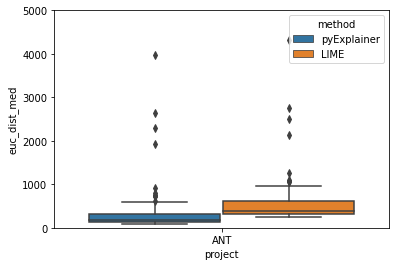

In [18]:
# 4. similarity of synthetic neighbours to instances (lime and pyExp)
from sklearn.metrics.pairwise import  euclidean_distances
results = pd.DataFrame()

for i in range(len(test_data_x)):
    X_explain = test_data_x.iloc[[i]]
    row_index = str(X_explain.index[0])
    pyExplanation = pyexplanations[i]
    limeExplanation = lime_explanations[i]
    #calculate euclidean distance between X_explain and synthetic data
    py_euc = euclidean_distances(X_explain.values,pyExplanation['synthetic_data'].values)
    lime_euc = euclidean_distances(X_explain.values,limeExplanation['synthetic_instance_for_global_model'])
    #calculate median 
    py_euc_med = np.median(py_euc)
    lime_euc_med = np.median(lime_euc)
    pyExp_series = pd.Series(data=[project_name,row_index,'pyExplainer',py_euc_med])
    limeExp_series = pd.Series(data=[project_name,row_index,'LIME',lime_euc_med])
    # results = results.append(pyExp_series, ignore_index=True)
    # results = results.append(limeExp_series, ignore_index=True)
    results = pd.concat([results,pyExp_series.to_frame(1).T], ignore_index = True)
    results = pd.concat([results,limeExp_series.to_frame(1).T], ignore_index = True)


results.columns = ['project','name', 'method', 'euc_dist_med']
results.to_csv('./eval_results/'+'4_'+ project_name+'_'+'SVM'+'.csv',index=False)

ant_svm = pd.read_csv('./eval_results/'+'4_ANT_SVM.csv')
    
ax= sns.boxplot(data=ant_svm, x='project',y='euc_dist_med', hue='method')
ax.set(ylim=(0, 5000))
plt.show()

Test for LR model

In [4]:
# Train model for ANT 
ant_project.train_global_model('LR')
global_model = ant_project.models['LR']

X_test = ant_project.X_test
y_test = ant_project.y_test
X_train = ant_project.X_train_rs
y_train = ant_project.y_train_rs
project_name = ant_project.name

# predict model
pred = global_model.predict(X_test)
defect_prob = global_model.predict_proba(X_test)[:,1]

# evaluate model preformance
evaluate_model_performance(ant_project,'LR')

Dataset project: ANT
LR Training accuracy(in %): 78.57142857142857
LR Test accuracy(in %): 76.10738255033557
LR precision(in %): 47.05882352941176
LR recall(in %): 57.831325301204814
LR f1(in %): 51.891891891891895


/anaconda/envs/xaienv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
true_f = [ np.abs(x) for x in global_model.coef_[0]]
# feature_importances = pd.Series(data=true_f,index=X_test.columns)
feature_importances = pd.Series(data=true_f)
feature_importances = feature_importances.sort_values(ascending=False)

true_features = feature_importances[:10]
true_features_indices = feature_importances[:10].index

print(true_features)



1     0.711334
9     0.253916
14    0.197973
0     0.153669
13    0.150815
15    0.148287
4     0.093043
18    0.089233
16    0.073495
19    0.068478
dtype: float64


In [20]:
# generate lime explanations
from lime.lime_tabular import LimeTabularExplainer
lime_file = 'explanations/' + project_name + '_LR_lime_explanations' +'.pkl'
limeExp = LimeTabularExplainer(X_train.values, 
                                      feature_names=X_test.columns, class_names=class_label, 
                                      random_state=random_state)
if os.path.exists(lime_file):
    lime_explanations = pickle.load(open(lime_file,'rb'))
else:
    lime_explanations = generate_explanations(limeExp,test_data_x,test_data_y,global_model)
    pickle.dump(lime_explanations,open(lime_file,'wb'))

In [21]:
# generate pyexplainer explanations
from pyexplainer.pyexplainer_pyexplainer import *
pyExp = PyExplainer(X_train, y_train, X_test.columns, dep, global_model, class_label)
pyExp_file = 'explanations/' + project_name + '_LR_pyExp_explanations' +'.pkl'
if os.path.exists(pyExp_file):
    pyexplanations = pickle.load(open(pyExp_file,'rb'))
else:
    pyexplanations = generate_explanations(pyExp,test_data_x,test_data_y,global_model)
    pickle.dump(pyexplanations,open(pyExp_file,'wb'))

In [22]:
# generate shap explanations
import shap
from shap import KernelExplainer

f = lambda x: global_model.predict_proba(x)[:,1]
shapExp = KernelExplainer(f, X_test)
shap_file = 'explanations/' + project_name + '_LR_shap_explanations' +'.pkl'
if os.path.exists(shap_file):
    shap_explanations = pickle.load(open(shap_file,'rb'))
else:
    shap_explanations = generate_explanations(shapExp,test_data_x,test_data_y,global_model)
    pickle.dump(shap_explanations,open(shap_file,'wb'))

Using 745 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [23]:
# get predictions for global, lime, pyexplainer, shap
lime_preds = [list(exp['rule'].local_pred.values())[0][0] for exp in lime_explanations] #lime local prediction probabilities
global_preds = [exp['rule'].predict_proba[1] for exp in lime_explanations] #global pred probas
py_preds = [exp['local_model'].predict_proba(exp['X_explain'].values)[0][1] for exp in pyexplanations]
shap_preds = [shapExp.expected_value + sum(exp['shap_values']) for exp in shap_explanations]

In [24]:
# 1. Accuracy test
print('lime')
print('precision: ', metrics.precision_score(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
# print(metrics.log_loss (np.array(global_preds)>0.5,np.array(lime_preds)>0.5))
print('avg probability diff: ',avg_proba_diff(global_preds, lime_preds))

print('pyExplainer')
print('precision: ',metrics.precision_score(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(py_preds)>0.5))
print('avg probability diff: ',avg_proba_diff(global_preds, py_preds))

print('shap')
print('precision: ',metrics.precision_score(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
print('recall: ',metrics.recall_score(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
print('mac: ',metrics.matthews_corrcoef(np.array(global_preds)>0.5,np.array(shap_preds)>0.5))
print('avg probability diff: ',avg_proba_diff(global_preds, shap_preds))

lime
precision:  0.7647058823529411
recall:  0.9512195121951219
mac:  0.7357622551523697
avg probability diff:  1.3507498292789981
pyExplainer
precision:  0.8636363636363636
recall:  0.926829268292683
mac:  0.817564924708696
avg probability diff:  0.6996980264785975
shap
precision:  1.0
recall:  1.0
mac:  1.0
avg probability diff:  2.1759842988637172e-16


In [25]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')
# 2. faithfulness test (lime and shap)
# 3. monotonicity test (lime and shap)
lime_faithfulness = []
lime_monotonicity = []
shap_faithfulness = []
shap_monotonicity = []
for i in range(len(test_data_x)):
    local_preds = list(lime_explanations[i]['rule'].local_pred.values())[0][0]
    name = lime_explanations[i]['name']
    lime_exp = lime_explanations[i]['rule']
    x = test_data_x.iloc[i].values # data row type ndarray
    coefs = np.zeros(x.shape[0])  # coefficients (weights) corresponding to attribute importance
    # pred_class = int(np.round(global_preds[i]))
    for v in lime_exp.local_exp[1]:
        coefs[v[0]] = v[1]
    base = np.zeros(x.shape[0])
    fmlime = faithfulness(global_model,x,coefs,base)
    lime_faithfulness.append(fmlime)
    mlime = monotonicity(global_model,x,coefs,base)
    lime_monotonicity.append(mlime)

    coefs_shap = shap_explanations[i]['shap_values']
    fmshap = faithfulness(global_model,x,coefs_shap,base)
    shap_faithfulness.append(fmshap)
    mshap = monotonicity(global_model,x,coefs_shap,base)
    shap_monotonicity.append(mshap)
    # print('Lime local prediction ' , local_preds)
    # print('Global model prediction', lime_explanations[0]['rule'].predict_proba[1]) #global model prediction
lime_avg_faithfulness = sum(lime_faithfulness)/len(lime_faithfulness)
lime_percentage_monotonicity = sum(lime_monotonicity)/len(lime_monotonicity)
shap_avg_faithfulness = sum(shap_faithfulness)/len(shap_faithfulness)
shap_percentage_monotonicity = sum(shap_monotonicity)/len(shap_monotonicity)
print(lime_avg_faithfulness)
print(lime_percentage_monotonicity)
print(shap_avg_faithfulness)
print(shap_percentage_monotonicity)
       

0.1604754360396062
0.0
0.14449669075351795
0.0


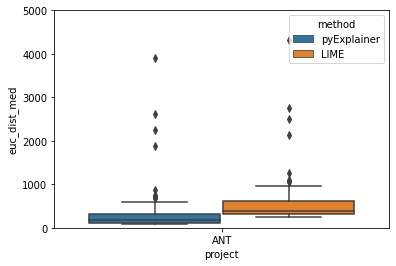

In [26]:
# 4. similarity of synthetic neighbours to instances (lime and pyExp)
from sklearn.metrics.pairwise import  euclidean_distances
results = pd.DataFrame()

for i in range(len(test_data_x)):
    X_explain = test_data_x.iloc[[i]]
    row_index = str(X_explain.index[0])
    pyExplanation = pyexplanations[i]
    limeExplanation = lime_explanations[i]
    #calculate euclidean distance between X_explain and synthetic data
    py_euc = euclidean_distances(X_explain.values,pyExplanation['synthetic_data'].values)
    lime_euc = euclidean_distances(X_explain.values,limeExplanation['synthetic_instance_for_global_model'])
    #calculate median 
    py_euc_med = np.median(py_euc)
    lime_euc_med = np.median(lime_euc)
    pyExp_series = pd.Series(data=[project_name,row_index,'pyExplainer',py_euc_med])
    limeExp_series = pd.Series(data=[project_name,row_index,'LIME',lime_euc_med])
    # results = results.append(pyExp_series, ignore_index=True)
    # results = results.append(limeExp_series, ignore_index=True)
    results = pd.concat([results,pyExp_series.to_frame(1).T], ignore_index = True)
    results = pd.concat([results,limeExp_series.to_frame(1).T], ignore_index = True)


results.columns = ['project','name', 'method', 'euc_dist_med']
results.to_csv('./eval_results/'+'4_'+ project_name+'_'+'LR'+'.csv',index=False)

ant_svm = pd.read_csv('./eval_results/'+'4_ANT_LR.csv')
    
ax= sns.boxplot(data=ant_svm, x='project',y='euc_dist_med', hue='method')
ax.set(ylim=(0, 5000))
plt.show()


Camel project SVM 

In [2]:
camel_project = Project('CAMEL')
camel_project.set_train_test()

# Train model for CAMEL 
camel_project.train_global_model('SVM')
global_model = camel_project.models['SVM']

X_test = camel_project.X_test
y_test = camel_project.y_test
X_train = camel_project.X_train
y_train = camel_project.y_train
project_name = camel_project.name

# predict model
pred = global_model.predict(X_test.values)
defect_prob = global_model.predict_proba(X_test.values)[:,1]

# evaluate model preformance
evaluate_model_performance(camel_project,'SVM')

Dataset project: CAMEL
SVM Training accuracy(in %): 83.8302752293578
SVM Test accuracy(in %): 80.72538860103627
SVM precision(in %): 100.0
SVM recall(in %): 1.0638297872340425
SVM f1(in %): 2.1052631578947367


In [3]:
test_data_x, test_data_y, sampled_data = camel_project.sample(100,X_test,y_test)

In [5]:
print(len(test_data_y[test_data_y==True]))

46


In [8]:
limeExp,lime_explanations = get_explanations(camel_project, 'lime','SVM',X_train,y_train,global_model )

In [9]:
pyExp,py_explanations = get_explanations(camel_project, 'pyExp','SVM',X_train,y_train,global_model )


In [10]:
shapExp,shap_explanations = get_explanations(camel_project, 'shap','SVM',X_train,y_train,global_model )

Using 872 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
# get predictions for global, lime, pyexplainer, shap
lime_preds = [list(exp['rule'].local_pred.values())[0][0] for exp in lime_explanations] #lime local prediction probabilities
global_preds = [exp['rule'].predict_proba[1] for exp in lime_explanations] #global pred probas
py_preds = [exp['local_model'].predict_proba(exp['X_explain'].values)[0][1] for exp in pyexplanations]
shap_preds = [shapExp.expected_value + sum(exp['shap_values']) for exp in shap_explanations]

In [8]:
# Train model for CAMEL 
camel_project.train_global_model('LR')
global_model = camel_project.models['LR']

X_test = camel_project.X_test
y_test = camel_project.y_test
X_train = camel_project.X_train
y_train = camel_project.y_train
project_name = camel_project.name

# predict model
pred = global_model.predict(X_test.values)
defect_prob = global_model.predict_proba(X_test.values)[:,1]

# evaluate model preformance
evaluate_model_performance(camel_project,'LR')

Dataset project: CAMEL
LR Training accuracy(in %): 84.40366972477065
LR Test accuracy(in %): 80.31088082901555
LR precision(in %): 47.72727272727273
LR recall(in %): 11.170212765957446
LR f1(in %): 18.103448275862068


In [9]:
lime_explanations = get_explanations(camel_project, 'lime','LR',X_train,y_train,global_model )

In [10]:
py_explanations = get_explanations(camel_project, 'pyExp','LR',X_train,y_train,global_model )


In [11]:
shap_explanations = get_explanations(camel_project, 'shap','LR',X_train,y_train,global_model )

Using 872 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


explanation/CAMEL_LR_shap_explanations.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

ANT KNN test

In [4]:
# Train model for ANT 
ant_project.train_global_model('KNN')
global_model = ant_project.models['KNN']

X_test = ant_project.X_test
y_test = ant_project.y_test
X_train = ant_project.X_train
y_train = ant_project.y_train
project_name = ant_project.name

# predict model
pred = global_model.predict(X_test)
defect_prob = global_model.predict_proba(X_test)

# evaluate model preformance
evaluate_model_performance(ant_project,'KNN')


Dataset project: ANT
KNN Training accuracy(in %): 85.47008547008546
KNN Test accuracy(in %): 78.12080536912752
KNN precision(in %): 50.90909090909091
KNN recall(in %): 50.602409638554214
KNN f1(in %): 50.755287009063444


In [14]:
limeExp,lime_explanations = get_explanations(project_name, 'lime','KNN',X_train,y_train,global_model )

In [15]:
pyExp,pyexplanations = get_explanations(project_name, 'pyExp','KNN',X_train,y_train,global_model )

In [16]:
shapExp,shap_explanations = get_explanations(project_name, 'shap','KNN',X_train,y_train,global_model )

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
Using 351 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [17]:
# get predictions for global, lime, pyexplainer, shap
lime_preds = [list(exp['rule'].local_pred.values())[0][0] for exp in lime_explanations] #lime local prediction probabilities
global_preds = [exp['rule'].predict_proba[1] for exp in lime_explanations] #global pred probas
py_preds = [exp['local_model'].predict_proba(exp['X_explain'].values)[0][1] for exp in pyexplanations]
shap_preds = [shapExp.expected_value + sum(exp['shap_values']) for exp in shap_explanations]

In [20]:
show_model_performance(global_preds,lime_preds,py_preds,shap_preds)

lime
precision:  0.8055555555555556
recall:  0.8787878787878788
mac:  0.7585219479387523
avg probability diff:  0.12624786875851654
pyExplainer
precision:  0.9117647058823529
recall:  0.9393939393939394
mac:  0.8880153842205367
avg probability diff:  0.1641976366779697
shap
precision:  1.0
recall:  1.0
mac:  1.0
avg probability diff:  1.1102230246251566e-18


In [21]:
import warnings
warnings.filterwarnings(action='ignore')
lime_faithfulness,lime_monotonicity,shap_faithfulness,shap_monotonicity = faithfulness_and_monotonicity(test_data_x,lime_explanations, shap_explanations)

lime_avg_faithfulness:  nan
lime_percentage_monotonicity:  0.54
shap_avg_faithfulness:  nan
shap_percentage_monotonicity:  0.62


In [34]:
import warnings
warnings.filterwarnings(action='ignore')
# 2. faithfulness test (lime and shap)
# 3. monotonicity test (lime and shap)
lime_faithfulness = []
lime_monotonicity = []
shap_faithfulness = []
shap_monotonicity = []
for i in range(len(test_data_x)):
    local_preds = list(lime_explanations[i]['rule'].local_pred.values())[0][0]
    name = lime_explanations[i]['name']
    lime_exp = lime_explanations[i]['rule']
    x = test_data_x.iloc[i].values # data row type ndarray
    coefs = np.zeros(x.shape[0])  # coefficients (weights) corresponding to attribute importance
    # pred_class = int(np.round(global_preds[i]))
    for v in lime_exp.local_exp[1]:
        coefs[v[0]] = v[1]
    base = np.zeros(x.shape[0])
    fmlime = faithfulness(global_model,x,coefs,base)
    lime_faithfulness.append(fmlime)
    mlime = monotonicity(global_model,x,coefs,base)
    lime_monotonicity.append(mlime)

    coefs_shap = shap_explanations[i]['shap_values']
    fmshap = faithfulness(global_model,x,coefs_shap,base)
    shap_faithfulness.append(fmshap)
    mshap = monotonicity(global_model,x,coefs_shap,base)
    shap_monotonicity.append(mshap)
    # print('Lime local prediction ' , local_preds)
    # print('Global model prediction', lime_explanations[0]['rule'].predict_proba[1]) #global model prediction
lime_avg_faithfulness = sum(lime_faithfulness)/len(lime_faithfulness)
lime_percentage_monotonicity = sum(lime_monotonicity)/len(lime_monotonicity)
shap_avg_faithfulness = sum(shap_faithfulness)/len(shap_faithfulness)
shap_percentage_monotonicity = sum(shap_monotonicity)/len(shap_monotonicity)

[0.6 0.6 0.6 0.6 0.8 1.  0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.4
 0.6 0.6]
[0.6 0.6 0.6 0.6 0.8 1.  0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.4
 0.6 0.6]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.8 0.8 0.8 0.8 0.8 0.4 0.8 0.8 0.8 0.8 0.6 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8]
[0.8 0.8 0.8 0.8 0.8 0.4 0.8 0.8 0.8 0.8 0.6 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 1.  0.8 0.8 0.8 0.8 0.8 0.8 1.
 0.8 0.8]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 1.  0.8 0.8 0.8 0.8 0.8 0.8 1.
 0.8 0.8]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.6 0.6

ANT NB test

In [42]:
import importlib
import project
from project import Project 
importlib.reload(project)

<module 'project' from '/mnt/batch/tasks/shared/LS_root/mounts/clusters/zcabswy1/code/Users/zcabswy/xai-swe/project.py'>

In [11]:
# Train model for ANT 
ant_project.train_global_model('NB')
global_model = ant_project.models['NB']

X_test = ant_project.X_test
y_test = ant_project.y_test
X_train = ant_project.X_train
y_train = ant_project.y_train
project_name = ant_project.name

# predict model
pred = global_model.predict(X_test)
defect_prob = global_model.predict_proba(X_test)

# evaluate model preformance
evaluate_model_performance(ant_project,'NB')

Dataset project: ANT
NB Training accuracy(in %): 79.77207977207978
NB Test accuracy(in %): 79.06040268456375
NB precision(in %): 53.246753246753244
NB recall(in %): 49.39759036144578
NB f1(in %): 51.24999999999999


In [12]:
limeExp,lime_explanations = get_explanations(project_name, 'lime','NB',X_train,y_train,global_model )

--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but GaussianNB was fitted with feature names


In [13]:
pyExp,pyexplanations = get_explanations(project_name, 'pyExp','NB',X_train,y_train,global_model )

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


1


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


2


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


3


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


5


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


6


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


7


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


8


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


9


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


10


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


11


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


12


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


13


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


14


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


15


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


16


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


17


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


18


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


19


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


20


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


21


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


22


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


23


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


24


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


25


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


26


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


27


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


28


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


29


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


30


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


31


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


32


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


33


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


34


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


35


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


36


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


37


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


38


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


39


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


40


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


41


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


42


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


43


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


44


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


45


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


46


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


47


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


48


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


49


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


50


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


51


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


52


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


53


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


54


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


55


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


56


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


57


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


58


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


59


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


60


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


61


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


62


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


63


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


64


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


65


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


66


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


67


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


68


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


69


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


70


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


71


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


72


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


73


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


74


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


75


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


76


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


77


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


78


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


79


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


80


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


81


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


82


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


83


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


84


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


85


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


86


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


87


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


88


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


89


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


90


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


91


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


92


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


93


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


94


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


95


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


96


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


97


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


98


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


99


In [14]:
shapExp,shap_explanations = get_explanations(project_name, 'shap','NB',X_train,y_train,global_model )

X does not have valid feature names, but GaussianNB was fitted with feature names
Using 351 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
The default of 'normalize' will be set to Fal

CAMEL knn

In [16]:
camel_project = Project('CAMEL')
camel_project.set_train_test()
camel_project.prepare_data()

# Train model for CAMEL 
camel_project.train_global_model('KNN')
global_model = camel_project.models['KNN']

X_test = camel_project.X_test
y_test = camel_project.y_test
X_train = camel_project.X_train
y_train = camel_project.y_train
project_name = camel_project.name

# predict model
pred = global_model.predict(X_test)
defect_prob = global_model.predict_proba(X_test)

# evaluate model preformance
evaluate_model_performance(camel_project,'KNN')

Dataset project: CAMEL
KNN Training accuracy(in %): 85.89449541284404
KNN Test accuracy(in %): 78.54922279792747
KNN precision(in %): 34.92063492063492
KNN recall(in %): 11.702127659574469
KNN f1(in %): 17.52988047808765


In [17]:
test_data_x, test_data_y, sampled_data = sample(100,X_test,y_test)

In [18]:
lime_explanations = get_explanations(project_name, 'lime','KNN',X_train,y_train,global_model )

--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
Bad pipe message: %s [b'\xdc\xd32\x0b3\x90\xf4\xedhX,\x03Q\xd4\xfe\xefX\xed \xc8\xf8\x16\xe21\x932E\xa4\xd8Z\xac\x1fk\x00\xf7\xcc\xf6\xd1j\x10\xee\xfd\xbf\x12Et\x9d[\x1d\x8eG\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00', b'\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05']
Bad pipe message: %s [b'\x03\x08']
Bad pipe message: %s [b'\x18Q\xcc\xda\x88\x06\xad\x8bY\x99\x94\xa1\x11{\xb8\xba/\x0f\x00\x00\xf4\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\x00', b"\x87\x00\x86\x00\x85\xc0\x19\x00\xa7\x00m\x00:\x00\x89\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\x00\x84\xc0/\xc0+\xc0'\xc0#\xc0\x13\xc0\t\x00\xa4\x00\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003\x002\x001\

--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


--------------------------------------------------------------------------------


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [19]:
py_explanations = get_explanations(project_name, 'pyExp','KNN',X_train,y_train,global_model )


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


1


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


2


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


3


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


5


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


6


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


7


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


8


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


9


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


10


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


11


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


12


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


13


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


14


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


15


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


16


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


17


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


18


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


19


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


20


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


21


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


22


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


23


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


24


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


25


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


26


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


27


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


28


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


29


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


30


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


31


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


32


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


33


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


34


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


35


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


36


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


37


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


38


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


39


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


40


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


41


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


42


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


43


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


44


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


45


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


46


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


47


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


48


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


49


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


50


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


51


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


52


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


53


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


54


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


55


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


56


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


57


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


58


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


59


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


60


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


61


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


62


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


63


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


64


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


65


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


66


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


67


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


68


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


69


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


70


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


71


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


72


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


73


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


74


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


75


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


76


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


77


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


78


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


79


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


80


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


81


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


82


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


83


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


84


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


85


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


86


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


87


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


88


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


89


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


90


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


91


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


92


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


93


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


94


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


95


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


96


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


97


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


98


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


99


In [20]:
shap_explanations = get_explanations(project_name, 'shap','KNN',X_train,y_train,global_model )

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
Using 872 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
The d

Camel project NB

In [4]:
camel_project = Project('CAMEL')
camel_project.set_train_test()
camel_project.prepare_data()

# Train model for CAMEL 
camel_project.train_global_model('NB')
global_model = camel_project.models['NB']

X_test = camel_project.X_test
y_test = camel_project.y_test
X_train = camel_project.X_train
y_train = camel_project.y_train
project_name = camel_project.name

# predict model
pred = global_model.predict(X_test)
defect_prob = global_model.predict_proba(X_test)[:,1]

# evaluate model preformance
evaluate_model_performance(camel_project,'NB')

test_data_x, test_data_y, sampled_data = camel_project.get_sampled_data()

Dataset project: CAMEL
NB Training accuracy(in %): 79.70183486238533
NB Test accuracy(in %): 75.75129533678756
NB precision(in %): 34.02777777777778
NB recall(in %): 26.063829787234045
NB f1(in %): 29.51807228915663


X has feature names, but GaussianNB was fitted without feature names
X has feature names, but GaussianNB was fitted without feature names
X has feature names, but GaussianNB was fitted without feature names
X has feature names, but GaussianNB was fitted without feature names


In [10]:
lime_explanations = get_explanations(camel_project, 'lime','NB',X_train,y_train,global_model )

explanations/CAMEL_NB_lime_explanations.pkl
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
-----------------------------------------------------------------

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
py_explanations = get_explanations(camel_project, 'pyExp','NB',X_train,y_train,global_model )


In [26]:
shap_explanations = get_explanations(camel_project, 'shap','NB',X_train,y_train,global_model )

Using 872 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


explanations/CAMEL_NB_shap_explanations.pkl


  0%|          | 0/100 [00:00<?, ?it/s]